# Comparing Boosting Methods in `tidymodels` 🚀

And among others:
- hyperparameter tuning using a space filling design
- out-of-sample fit scoring

First importing the relevant libraries:

In [1]:
# Libraries
library(tidyverse)
library(tidymodels)
library(doParallel)
library(vip)
library(lubridate)
library(broom)
library(scales)
library(bonsai)

# Chart Theme
theme_set(theme_bw() +
          theme(plot.title = element_text(size = 14, face = "bold"),
                plot.subtitle = element_text(size = 10, face = "italic",
                                             colour = "grey50")))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.0.0     ✔ tune         1.0.1
✔ infer        1.0.3     ✔ workflows    1.1.0
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.2     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [2]:
dt_train <- read_csv("train.csv", show_col_types = F)
dt_test <- read_csv("test.csv", show_col_types = F)
folds <- vfold_cv(dt_train, v = 3)

Rows: 1003 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 335 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): sex, smoker, region
dbl (4): age, bmi, children, charges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## One quick chart

This week, I started with Python and then translated to R. Therefore, I won't redo the same charts, I already did with `plotnine`, but will make a new one that would be much harder to do in Python:

In [ ]:
dt_train %>% 
  select(where(is.character), charges) %>% 
  pivot_longer(-charges) %>% 
  mutate(charges = charges/1000) %>% 
  ggplot(aes(charges, 
             value %>% reorder_within(charges, name),
             fill = name)) +
  geom_density_ridges(scale = 1.5, alpha = 0.5, size = 0.25) +
  facet_wrap(~ name, scales = "free") +
  scale_y_reordered() +
  scale_x_continuous(labels = dollar_format(suffix = "k")) +
  ggsci::scale_fill_futurama() +
  labs(title = "Density of Charges by Nominal Predictor Value",
       y = NULL, x = "Charges") +
  theme(legend.position = "none",
        strip.background = element_rect(fill = alpha("black", 0.1)),
        strip.text = element_text(face = "bold", size = 10))

In [ ]:
# Save for the markdown file
ggsave(file = "ridges.png", dpi = 350, width = 6, height = 3)

## Continue with the models

Building both models in `tidymodels` includes:
- the model specification, including the `engine` and `mode`
- the `recipe`, including all preprocessing steps

In [23]:
# XGBoost Model
xg_wflow <- workflow() %>% 
  add_model(
    boost_tree(trees = tune(),
               tree_depth = tune(),
               min_n = tune(),
               loss_reduction = tune(),
               sample_size = tune(),
               mtry = tune(),
               learn_rate = tune()) %>%
      set_engine("xgboost", importance = "impurity") %>%
      set_mode("regression")
  ) %>% 
  add_recipe(
    recipe(charges ~ ., data = dt_train) %>% 
      step_novel(all_nominal_predictors()) %>% 
      step_normalize(all_numeric_predictors()) %>% 
      step_dummy(all_nominal_predictors(), one_hot = TRUE),
    blueprint = hardhat::default_recipe_blueprint(allow_novel_levels = TRUE)
  )

In [45]:
# Hyperparameter Tuning XGBoost
start_time <- Sys.time()
unregister_dopar <- function() {
  env <- foreach:::.foreachGlobals
  rm(list=ls(name=env), pos=env)
}

cl <- makePSOCKcluster(7)
registerDoParallel(cl)

xg_tune <- tune_grid(object = xg_wflow,
                     resamples = folds,
                     grid = grid_latin_hypercube(
                       trees(),
                       tree_depth(),
                       min_n(),
                       loss_reduction(),
                       sample_size = sample_prop(),
                       finalize(mtry(), dt_train),
                       learn_rate(),
                       size = 100
                     ))

stopCluster(cl)
unregister_dopar()
Sys.time() - start_time

xg_tune %>% 
  show_best(metric = "rmse") %>% 
  select(.metric, mean, std_err, n)

.metric,mean,std_err,n
<chr>,<dbl>,<dbl>,<int>
rmse,4681.691,305.5070,3
rmse,4720.669,279.1093,3
rmse,4729.883,272.8867,3
rmse,4741.291,274.6010,3
rmse,4752.347,284.3850,3


In [28]:
# LGBM Model
lgbm_wflow <- workflow() %>% 
  add_model(
    boost_tree(trees = tune(),
               tree_depth = tune(),
               min_n = tune(),
               loss_reduction = tune(),
               mtry = tune(),
               learn_rate = tune()) %>%
      set_engine("lightgbm", objective="mse") %>%
      set_mode("regression")
  ) %>% 
  add_recipe(
    recipe(charges ~ ., data = dt_train) %>% 
      step_novel(all_nominal_predictors()) %>% 
      step_normalize(all_numeric_predictors()) %>% 
      step_dummy(all_nominal_predictors(), one_hot = TRUE),
    blueprint = hardhat::default_recipe_blueprint(allow_novel_levels = TRUE)
  )

In [44]:
# Hyperparameter Tuning LGBM
start_time <- Sys.time()
unregister_dopar <- function() {
  env <- foreach:::.foreachGlobals
  rm(list=ls(name=env), pos=env)
}

cl <- makePSOCKcluster(7)
registerDoParallel(cl)

lgbm_tune <- tune_grid(object = lgbm_wflow,
                       resamples = folds,
                       grid = grid_latin_hypercube(
                         trees(),
                         tree_depth(),
                         min_n(),
                         loss_reduction(),
                         finalize(mtry(), dt_train),
                         learn_rate(),
                         size = 100
                       ))

stopCluster(cl)
unregister_dopar()
Sys.time() - start_time

lgbm_tune %>% 
  show_best(metric = "rmse") %>% 
  select(.metric, mean, std_err, n)

.metric,mean,std_err,n
<chr>,<dbl>,<dbl>,<int>
rmse,4726.056,278.8142,3
rmse,4783.247,278.2388,3
rmse,4818.970,216.2120,3
rmse,4832.759,304.5370,3
rmse,4835.273,302.4014,3


Wow, the hyperparameter tuning for LGBM took a long time with `tidymodels`! Next up, fitting the models with the best hyperparameters from the tuning results:

In [46]:
# Fit the best models
xg_fit <- xg_wflow %>% 
  finalize_workflow(select_best(xg_tune, metric = "rmse")) %>% 
  fit(dt_train)

[20:30:57] WARNING: amalgamation/../src/learner.cc:627: 
Parameters: { "importance" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [47]:
lgbm_fit <- lgbm_wflow %>% 
  finalize_workflow(select_best(lgbm_tune, metric="rmse")) %>% 
  fit(dt_train)

With `tidymodels`, it's incredibly convenient to calculate multiple evaluation metrics in one step:

In [48]:
eval_metrics <- metric_set(rsq, mae, mape)

In [56]:
bind_rows(
    xg_fit %>%
        augment(dt_test) %>%
        mutate(model = "XGBoost"),
    lgbm_fit %>%
        augment(dt_test) %>%
        mutate(model = "LGBM")
) %>% 
  group_by(model) %>% 
  eval_metrics(truth = charges, estimate = .pred) %>% 
  select(-.estimator) %>% 
  pivot_wider(names_from = model, values_from = .estimate)

.metric,LGBM,XGBoost
<chr>,<dbl>,<dbl>
rsq,0.8736014,0.8775492
mae,2456.5254949,2182.5013151
mape,35.6821793,26.4608142


Contrary to Python, `XGBoost` worked better on the holdout data set.

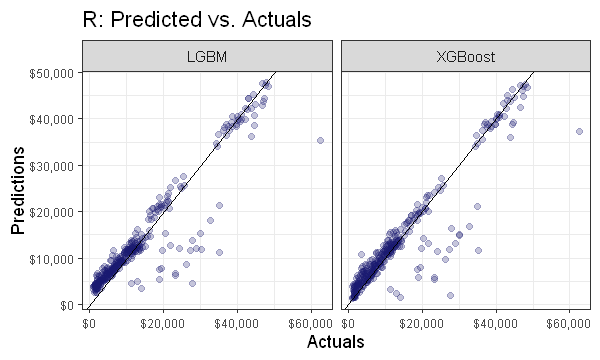

In [57]:
options(repr.plot.width = 5, repr.plot.height = 3)

bind_rows(
    xg_fit %>%
        augment(dt_test) %>%
        mutate(model = "XGBoost"),
    lgbm_fit %>%
        augment(dt_test) %>%
        mutate(model = "LGBM")
) %>%
    ggplot(aes(x = charges, y = .pred)) +
    geom_point(alpha = 0.25, colour = "midnightblue") +
    geom_abline() +
    labs(
        title = "R: Predicted vs. Actuals",
        x = "Actuals", y = "Predictions"
    ) +
    facet_wrap(~model) +
    scale_y_continuous(labels = dollar_format()) +
    scale_x_continuous(labels = dollar_format()) +
    theme_bw() +
    theme(axis.text = element_text(size = 7))

And that's it for this week. Couldn't invest much more time this week because of exams.

In [ ]:
ggsave(file = "R.png", dpi = 350, width = 4, height = 4)